# Hydrogeneration Analysis

This notebook combines catchment areas with ERA5 climate data to analyze hydrological characteristics:
- Processes catchment polygons from gauging stations
- Integrates ERA5 climate variables (runoff, temperature, precipitation, snow, evaporation)
- Calculates catchment-averaged values for hydrological analysis
- Supports hydropower generation assessment through water availability analysis

In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray # required to use rio
import matplotlib.pyplot as plt
import os

### User Inputs
 
- Rely on `catchment_areas.ipynb` for generating catchment polygons for each gauging station
- Use `preparation_era5_data.ipynb` for preprocessing ERA5 climatic data including:
    - Surface runoff (ro)
    - Temperature (t2m) 
    - Total precipitation (tp)
    - Snow depth (sd)
    - Potential evaporation (pev)
    - Evaporation (e)

In [2]:
catchment_geojson = 'catchment_files/stationbasins_guinea.geojson'
climatic_netcdf = 'era5_prepared_files/reanalysis-era5-land-monthly-means_GN_1950_2025_t2m_tp_ro_pev_e.nc'

folder_result = 'hydro_guinea'
if not os.path.exists(folder_result): os.makedirs(folder_result)

### Loading Data

In [3]:
data_catchment = gpd.read_file(catchment_geojson)
data_climatic = xr.open_dataset(climatic_netcdf, decode_timedelta=True)

## 🔍 Estimating Streamflow at Gauging Stations Using Climatic Data

This script processes a gridded NetCDF dataset (`data_climatic.nc`) containing climatic variables such as surface runoff (`ro`), and estimates streamflow at gauging stations using catchment polygons (`stationbasins.geojson`).

### **Workflow:**
1. **Load the NetCDF climatic dataset** (e.g. ERA5 reanalysis data) using `xarray`.
2. **Extract the `ro` variable** (surface runoff) from the dataset.
3. **Load the catchment shapefile** containing polygon geometries for each station.
4. **Reproject the shapefile** to match the dataset's coordinate system.
5. **Mask and average the surface runoff** over each catchment area.
6. **Multiply the average runoff by the catchment area** to estimate **streamflow** in m³/s.
7. The result is a time series of streamflow per station, which can be used for hydropower potential estimation.

### **Assumptions:**
- Runoff (`ro`) is in units of **mm/day**.
- Catchment area is given in square kilometers and converted to m² for consistency.
- Estimate streamflow (Q) in cubic meters per second (m³/s)

In [4]:

def calculate_streamflow(data_climatic, data_catchment):
    """
    Calculate streamflow from climatic data and catchment areas.
    :param data_climatic:
        xarray Dataset containing climatic data (e.g. ERA5)
    :param data_catchment:
        GeoDataFrame containing catchment polygons with area and station ID
    :return:
        DataFrame with streamflow estimates per station
    """

    data_runoff = data_climatic['ro']

    # Set spatial dimensions
    data_runoff = data_runoff.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    # Assign a CRS — make sure it's EPSG:4326 (WGS 84)
    data_runoff = data_runoff.rio.write_crs("EPSG:4326")  # or .write_crs(epsg=4326)

    # Reproject catchments to match dataset CRS (assuming dataset is lat/lon WGS84)
    if not data_catchment.crs:
        data_catchment = data_catchment.set_crs("EPSG:4326")  # default assumption
    data_catchment = data_catchment.to_crs(data_runoff.rio.crs if hasattr(data_runoff, 'rio') else "EPSG:4326")

    # Convert catchments to GeoJSON-like dicts
    features = data_catchment.geometry.__geo_interface__['features']

    results = []
    runoff_results = []
    area_results = []
    # Loop through each catchment
    for i, row in data_catchment.iterrows():

        # Convert the Shapely geometry to GeoJSON format
        geom = [row['geometry'].__geo_interface__]

        # Spatial clipping operation using the rioxarray package
        runoff_cropped = data_runoff.rio.clip(geom, data_catchment.crs)

        # Average over the spatial dimensions to get a time series
        runoff_mean = runoff_cropped.mean(dim=["latitude", "longitude"])

         # Keep original runoff values before converting to streamflow
        runoff_series = runoff_mean.expand_dims({"station": [row['station']]})
        runoff_results.append(runoff_series)

        # Calculate area in m²
        area_km2 = row['area'] if not np.isnan(row['area']) else row['area_calc']
        area_m2 = area_km2 * 1e6

        # Create constant DataArray with same time index
        area_da = xr.DataArray([area_m2] * runoff_mean.sizes['time'],
                               dims=["time"], coords={"time": runoff_mean["time"]})
        area_da = area_da.expand_dims({"station": [row['station']]})
        area_da.name = "area"
        area_results.append(area_da)

        # Streamflow (Q) = runoff * area
        streamflow = (runoff_mean / 1000) * area_m2 / 86400 # units: m³/s

        streamflow = streamflow.expand_dims({"station": [row['station']]})
        results.append(streamflow)

    # Combine into a DataFrame
    streamflow_df = xr.concat(results, dim='station')

    # Convert to DataFrame — dimensions are now fine for direct use
    streamflow_df = streamflow_df.to_dataframe().reset_index().pivot(index='time', columns='station', values=streamflow_df.name)

    # Combine into xarray Datasets
    runoff_combined = xr.concat(runoff_results, dim='station')
    area_combined = xr.concat(area_results, dim='station')

    # Convert both to DataFrames
    runoff_df = runoff_combined.to_dataframe().reset_index().pivot(index='time', columns='station', values=runoff_combined.name)
    area_df = area_combined.to_dataframe().reset_index().pivot(index='time', columns='station', values=area_combined.name)
    area_df = area_df / 1e6

    # Combine with MultiIndex columns
    output_df = pd.concat({'runoff:mm/day': runoff_df, 'streamflow:m3/s': streamflow_df}, axis=1) # , 'catchment:km2': area_df
    output_df.columns = output_df.columns.swaplevel(0, 1)
    output_df = output_df.sort_index(axis=1)

    output_df.columns.names = ['station', 'variable']

    output_df.round(1).to_csv(os.path.join(folder_result, 'full_data_monthly.csv'))
    return output_df

def format_wide_output(output_df):
    """
    Format the output DataFrame to separate runoff and streamflow data.
    :param output_df: DataFrame with MultiIndex columns
    :return: None
    """

    runoff = output_df.xs('runoff:mm/day', level='variable', axis=1).copy()
    # Create MultiIndex with year and month
    runoff.index = pd.MultiIndex.from_arrays([runoff.index.year, runoff.index.month], names=['year', 'month'])
    # Unstack month to columns
    runoff = runoff.unstack(level='month')
    # Sort index
    runoff = runoff.sort_index()
    runoff.round(1).to_csv(os.path.join(folder_result, 'runoff_monthly-mm-day.csv'))

    streamflow = output_df.xs('streamflow:m3/s', level='variable', axis=1).copy()
    # Create MultiIndex with year and month
    streamflow.index = pd.MultiIndex.from_arrays([streamflow.index.year, streamflow.index.month], names=['year', 'month'])
    # Unstack month to columns
    streamflow = streamflow.unstack(level='month')
    # Sort index
    streamflow = streamflow.sort_index()
    streamflow.round(1).to_csv(os.path.join(folder_result, 'streamflow_monthly-m3-s.csv'))

def calculate_yearly_avg(output_df):
    # 1. Extract number of days in each month
    days_in_month = output_df.index.days_in_month
    days_in_month = pd.Series(days_in_month.values, index=output_df.index, name="days")

    # 2. Extract year from the index
    years = output_df.index.year

    # 3. Multiply each row by the number of days in that month (broadcasts over all columns)
    weighted = output_df.multiply(days_in_month, axis=0)

    # 4. Group by year and sum weighted values
    weighted_sum = weighted.groupby(years).sum()

    # 5. Group days per year
    days_per_year = days_in_month.groupby(years).sum()

    # 6. Divide weighted sum by total days in that year
    yearly_avg = weighted_sum.divide(days_per_year, axis=0)

    streamflow_yearly_avg = yearly_avg.xs("streamflow:m3/s", level='variable', axis=1)
    streamflow_yearly_avg.round(0).to_csv(os.path.join(folder_result, 'streamflow_yearly_m3-s.csv'))

    runoff_yearly_avg = yearly_avg.xs("runoff:mm/day", level='variable', axis=1)
    runoff_yearly_avg = runoff_yearly_avg * 365
    runoff_yearly_avg.round(0).to_csv(os.path.join(folder_result, 'runoff_yearly_avg-mm-year.csv'))

output_df = calculate_streamflow(data_climatic, data_catchment)
format_wide_output(output_df)
calculate_yearly_avg(output_df)

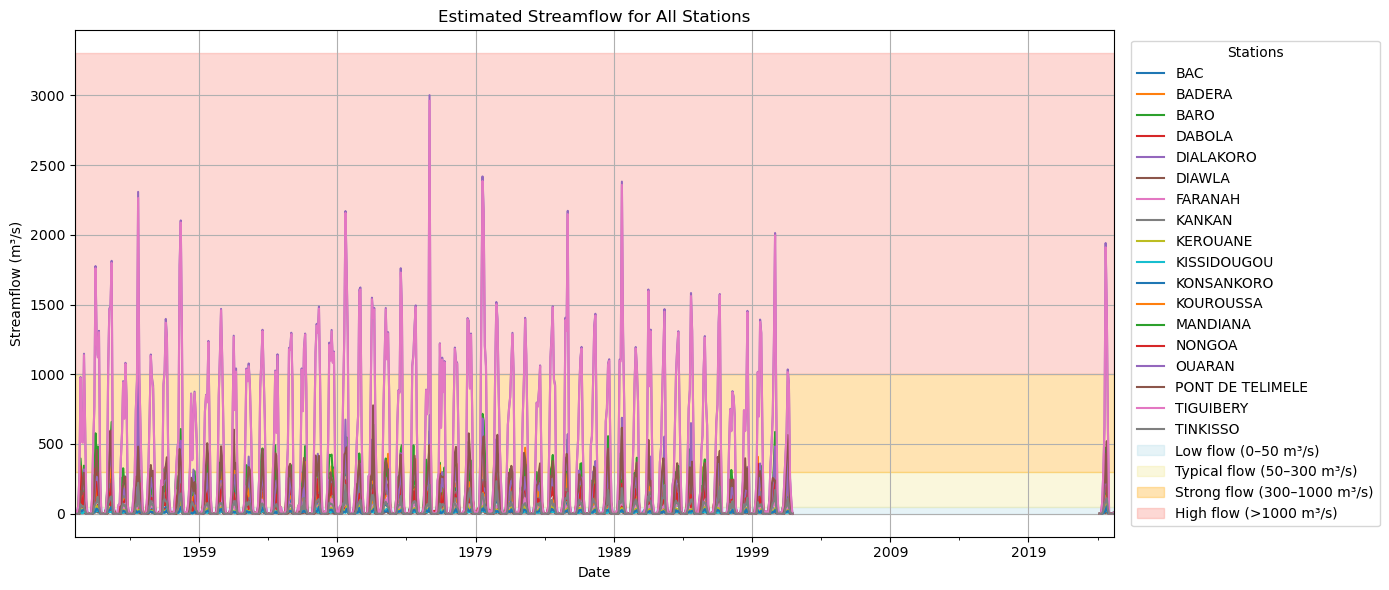

In [43]:
import matplotlib.pyplot as plt

def plot_streamflow(streamflow_df):
    """
    Simple line plot of streamflow time series for all stations,
    with legend placed outside the plot on the right.
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    streamflow_df.plot(linewidth=1.5, ax=ax)


    max_flow = streamflow_df.max().max() * 1.1  # use max from all stations
    # Define benchmark flow zones consistent with interpretation table
    ax.axhspan(0, 50, color='lightblue', alpha=0.3, label='Low flow (0–50 m³/s)')
    ax.axhspan(50, 300, color='khaki', alpha=0.3, label='Typical flow (50–300 m³/s)')
    ax.axhspan(300, 1000, color='orange', alpha=0.3, label='Strong flow (300–1000 m³/s)')
    ax.axhspan(1000, max_flow, color='salmon', alpha=0.3, label='High flow (>1000 m³/s)')

    ax.set_title("Estimated Streamflow for All Stations")
    ax.set_xlabel("Date")
    ax.set_ylabel("Streamflow (m³/s)")
    ax.grid(True)

    # Place legend outside the plot area to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), title="Stations")

    plt.tight_layout()
    plt.show()

plot_streamflow(streamflow_df)

### Interpretation of Streamflow Ranges

| Streamflow (m³/s) | Interpretation                                                |
|-------------------|---------------------------------------------------------------|
| 0–50              | Likely small-to-medium catchments or dry season flows         |
| 50–300            | Very typical for West African rivers with moderate rainfall   |
| 300–600           | Strong seasonal rivers or larger catchments                   |
| 1000–2000+        | Major river flows — possibly the Niger, Tinkisso, or similar  |

## Elasticity

The Budyko framework is a widely used model to estimate the relationship between precipitation, potential evaporation, and runoff in a catchment area. It provides a way to understand how changes in climate variables (like temperature and precipitation) affect hydrological processes.
The Budyko model can be expressed as:

$$Q = P \cdot \left(1 - \frac{T}{T + 17.8}\right)$$
where:
- \( Q \) is the runoff,
- \( P \) is the precipitation,
- \( T \) is the mean annual temperature.

The model assumes that the runoff is a function of both precipitation and temperature, and it provides a way to estimate the sensitivity of runoff to changes in these variables.

In this context, we are interested in calculating the following:

1. **Runoff Coefficient (r)**: This is the ratio of average annual runoff to average annual precipitation.
2. **Precipitation Elasticity of Runoff $\epsilon_{QP}$**: This measures how sensitive runoff is to changes in precipitation.
3. **Temperature Sensitivity of Runoff $S_{QT}$**: This measures how sensitive runoff is to changes in temperature.
4. **Temperature Sensitivity of ET₀ $S_{ET0T}$**: This measures how sensitive potential evaporation is to changes in temperature.

In [1]:
import statsmodels.api as sm


data_climatic = data_climatic.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
data_climatic = data_climatic.rio.write_crs("EPSG:4326")
# Extract precipitation from dataset
data_precip = data_climatic['tp']  # assuming 'precip' is the name
#data_precip = data_precip.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

data_runoff = data_climatic['ro']


# Loop through catchments to extract mean runoff and precipitation per station
precip_results = []
runoff_results = []
elasticity_results = []

for i, row in data_catchment.iterrows():
    geom = [row['geometry'].__geo_interface__]

    # Clip both runoff and precipitation
    runoff_cropped = data_climatic['ro'].rio.clip(geom, data_catchment.crs)
    precip_cropped = data_climatic['tp'].rio.clip(geom, data_catchment.crs)

    # Average spatially to get time series
    runoff_mean = runoff_cropped.mean(dim=["latitude", "longitude"])
    precip_mean = precip_cropped.mean(dim=["latitude", "longitude"])

    # Combine into DataFrame
    df = xr.Dataset({'runoff': runoff_mean, 'tp': precip_mean}).to_dataframe().dropna()

    # Log-transform both for elasticity estimation
    df['log_runoff'] = np.log(df['runoff'])
    df['log_precip'] = np.log(df['tp'])

    # Linear regression: log_runoff ~ log_precip
    X = sm.add_constant(df['log_precip'])
    model = sm.OLS(df['log_runoff'], X).fit()

    elasticity = model.params['log_precip']

    elasticity_results.append({'station': row['station'], 'elasticity': elasticity})

    # Optional: store the full time series for plotting/debug
    runoff_ts = runoff_mean.expand_dims({"station": [row['station']]})
    precip_ts = precip_mean.expand_dims({"station": [row['station']]})
    runoff_results.append(runoff_ts)
    precip_results.append(precip_ts)

# Combine results
elasticity_df = pd.DataFrame(elasticity_results)

# Optional: also export time series
runoff_combined = xr.concat(runoff_results, dim='station')
precip_combined = xr.concat(precip_results, dim='station')

runoff_df = runoff_combined.to_dataframe().reset_index().pivot(index='time', columns='station', values=runoff_combined.name)
precip_df = precip_combined.to_dataframe().reset_index().pivot(index='time', columns='station', values=precip_combined.name)



NameError: name 'data_climatic' is not defined